# Final Model
### add explanation here

First, functions were created for all differential equations in the system.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import math

### Drug Release with Dissolution of Microneedle: 

In [2]:
#function for rate of drug released from dissolving microneedle
def eqn_rate_drug_release_MN (DRMN_time,theta,rho,h, cs, DCS_time,beta, kd):
    A = rho*np.pi*(np.tan(theta))**2
    deltaZMN = (3*DRMN_time/A)**(1.0/3.0)
    area_DMN = np.pi*np.tan(theta)/np.cos(theta)*(h**2-deltaZMN**2)+np.pi*(deltaZMN**2)*(np.tan(theta)**2)
    area_DMN = np.maximum(area_DMN,0)
    dDRMNdt = beta*kd*area_DMN*(cs-((1-beta)/beta)*DCS_time)
    dDRMNdt = np.maximum(dDRMNdt,0)
    return dDRMNdt

### Drug Release with Dissolution of Base Plate:

In [3]:
#function for baseplate drug release 
def eqn_rate_drug_release_BP(DRBP_time, rho, Bbp, DCS_time, beta,kd, hbp,cs):
    deltaZBP = DRBP_time/(rho*Bbp**2)
    area_DBP = 4*Bbp*(hbp - deltaZBP) + Bbp**2
    area_DBP = np.maximum(area_DBP,0)
    dDRBPdt = beta*kd*area_DBP*(cs-((1-beta)/beta)*DCS_time)
    dDRBPdt = np.maximum(dDRBPdt,0)
    return dDRBPdt

### Flux of Drug from Baseplate to Skin:

In [4]:
def eqn_rate_flux_drugBP_2skin (nMN, diff, hderm, hbp, DRBP_time, Vbp, DCS_time,r):
    dFDBPS = (2*diff*nMN*np.pi*r**2)/(hderm+hbp)*(DRBP_time/Vbp - DCS_time)
    return dFDBPS

### Concentration of Drug in Skin:

In [5]:
def eqn_rate_drug_concentration_skin(nMN,Vs,gamma, dDRMNdt,dFDBPS, DCS_time):
    dDCSdt = nMN/Vs*(dDRMNdt)+1/Vs*(dFDBPS)-gamma*DCS_time
    return dDCSdt

### Drug Concentration in Plasma

In [6]:
def eqn_change_DCP(DCS_time, Vs, Vbp, gamma, Clb,DCP_time, Qper,DCPer_time):
    dDCPdt = Vs/Vbp*gamma*DCS_time - 1/Vbp*(Clb*DCP_time + Qper* DCP_time - Qper*DCPer_time)
    return dDCPdt 

### Drug Concentration in Peripheral Compartment

In [7]:
def eqn_change_DCPer(Vper, Qper, DCP_time, DCPer_time):
    dDCPerdt = 1/Vper*(Qper* DCP_time - Qper*DCPer_time)
    return dDCPerdt

#### Now we can define the system of ODEs. First let set up the variabes:

In [8]:
#list of constants here
theta = 1 #in radians (0 - 0.7853)
rho =  1 #in ng/mL
h =  1 #in cm
cs = 1 #in ng/mL
beta = 1 #unitless 0-1
kd = 1 #cm/hr
gamma = 1 #unitless
nMN = 100 #number of needles in patch
Vs = 1 #mL
#Vn = np.pi*np.tan(theta)**2*((h**3)/3)#total volume of microneedle
Vn = 1
Vbp = 1 #volume baseplase
Bbp =1 #size of side base plate 
hbp = 1 #height of base pair
diff = 1 #drug diffusivity cm2/h
doseMN = beta*Vn*rho
doseBP = beta*Vbp*rho
r = 1 #radius cm
hderm = 1 #thickness of dermis in cm
Clb = 1 #systemic clearance of drug
Qper = 1 #intercompartment mass transfer rate
Vper = 1
dose = 3*10**5 #total dose ng
p_w = 1 #cm

### Define system of ODES
Also, we know that the drug release from the device is limited to the maximum dosage. Here we will add if statements to make sure that the drug release rate stays at zero when the maximum dosage is released from microneedles and baseplate. 

In [9]:
#add controls here to halt release once all drug has been released
controlMN = dose*Vn/(nMN*Vn+Vbp)
controlBP = dose - controlMN

In [10]:
def system_of_odes(t,y):
    DRMN_time, DRBP_time, DFBPS_time, DCS_time,DCP_time, DCPer_time  = y
    #y is a vector where y[0] = DRMN_time, y[1] = DRBP_time, y[2] = DFBPS_time, y[3] = DCS_time
    dDRMNdt = eqn_rate_drug_release_MN (DRMN_time,theta,rho,h, cs, DCS_time,beta, kd)
    if DRMN_time >= controlMN:
        dDRMNdt = 0
    dDRBPdt = eqn_rate_drug_release_BP(DRBP_time, rho, Bbp, DCS_time, beta,kd, hbp,cs)
    if DRBP_time >= controlBP:
         dDRBPdt = 0
    dFDBPS = eqn_rate_flux_drugBP_2skin (nMN, diff, hderm, hbp, DRBP_time, Vbp, DCS_time,r)
    if DRBP_time >= controlBP:
         dFDBPS = 0
    dDCSdt = eqn_rate_drug_concentration_skin(nMN,Vs,gamma, dDRMNdt,dFDBPS, DCS_time)
    dDCPdt = eqn_change_DCP(DCS_time, Vs, Vbp, gamma, Clb,DCP_time, Qper,DCPer_time)
    dDCPerdt = eqn_change_DCPer(Vper, Qper, DCP_time, DCPer_time)

    return [dDRMNdt,dDRBPdt,dFDBPS,dDCSdt,dDCPdt,dDCPerdt]


In [11]:
y0 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  # Initial conditions: [DRMN_time, DRBP_time, DFBPS_time, DCS_time, DCP_time, DCPer_time]
t_span = (0.0, 100.0)
t_eval = np.linspace(0.0, 100.0, 10)
sol = solve_ivp(system_of_odes, t_span, y0, method='RK45', t_eval=t_eval, rtol=1e-6, atol=1e-9)

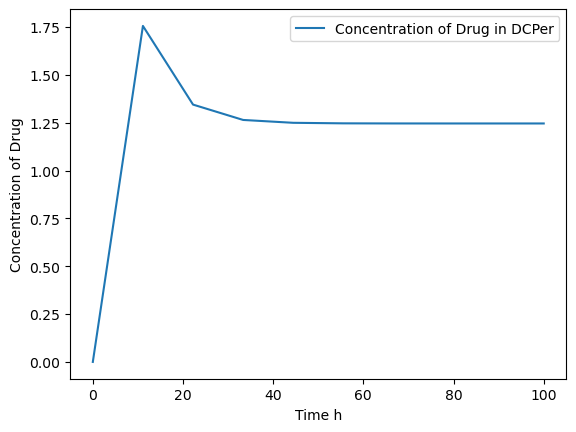

In [ ]:
#plt.plot(sol.t, sol.y[0], label='Released Drug(t) from MN')
#plt.plot(sol.t, sol.y[1], label='Released Drug(t) from BP')
#plt.plot(sol.t, sol.y[2], label='Flux Drug from BP to Skin')
#plt.plot(sol.t, sol.y[3], label='Concentration of Drug in Skin')
#plt.plot(sol.t, sol.y[4], label='Concentration of Drug in DCP')
#plt.plot(sol.t, sol.y[5], label='Concentration of Drug in DCPer')
plt.xlabel('Time h')
plt.ylabel('Concentration of Drug')
plt.legend()
plt.show()

In [13]:
print(sol.y[0])
print(controlMN)

print(sol.y[1])
print(controlBP)

controltot = controlMN + controlBP
print(controltot)

[ 0.         33.90289684 39.07030749 40.02091311 40.19957395 40.23328081
 40.23964462 40.24084627 40.24107317 40.24111602]
2970.29702970297
[0.   1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25]
297029.702970297
300000.0
